# Get familiar with a book without reading it
This is a short and simple notebook which demonstrates the creation of a graph which visualizes the connections network between the main places and people in a book.

I use the following tools:<br>
1. spaCy - An NLP (natural language processing) package, to perform NER (named entity recognition).
2. NetwrokX - A package for the creation and manipulation of complex networks.
3. [Cytoscape](https://cytoscape.org/) - An external software, used to visualize the graph.

I create the graph of the book ["The Adventures of Huckleberry Finn"](http://www.gutenberg.org/files/76/76-0.txt), by Mark Twain.

# Imports

In [27]:
import re
import spacy
from collections import Counter
import networkx as nx
from IPython.display import Image

# Extract the data

In [28]:
def _entity_normalizer(entity):
    """Returns a clean entity."""
    
    ent = entity.text.lower()
    ent = ent.replace('_','').replace('-','').replace('\'s','').replace('\n',' ').strip()
    if 'sid' in ent: return 'Sid Sawyer'
    if 'garrick' in ent: return 'David Garrick the younger'
    if 'emmeline' in ent: return 'Emmeline Grangerford'
    if 'huck' in ent or 'finn' in ent or 'huckleberry' in ent: return 'Huckleberry Finn'
    if ent == 'tom' or ent == 'sawyer'  or ent == 'tom sawyer': return 'Tom Sawyer'
    if 'orleans' in ent: return 'New Orleans'
    return ent.capitalize()

In [29]:
def get_entites_dict_from_paragraph(paragraph, nlp):
    """Returns a dictionary with entities from input paragraph."""
    
    # instantiate output dictionary
    output = {'GPE': set(), 'PERSON': set()}
    
    # process paragraph
    doc = nlp(paragraph)
    
    # extract places and people entities
    for entity in doc.ents:
        if entity.label_ == 'GPE' or entity.label_ == 'PERSON':
            output[entity.label_].add(_entity_normalizer(entity))  # clean the entity
            
    # return the dictionary if contains at least 2 entities
    return output if len(output['GPE']) + len(output['PERSON']) >= 2 else None

In [30]:
def get_edges_from_entities(entities):
    """
    Returns a list of edges between entities.
    
    An edge is created if 2 entities appear on the same paragraph.
    """
    
    edges = set()
    
    # links of person and place
    for loc in entities['GPE']:
        for person in entities['PERSON']:
            if loc==person:  # in case spacy identified a person as a location (happens to Jim)
                continue
            edges.add(((loc, 'loc'), (person, 'prs')))
    
    # links of people
    for person_1 in entities['PERSON']:
        for person_2 in entities['PERSON']:
            # skip same person links
            if person_1==person_2:
                continue
            if person_1 > person_2:
                person_1, person_2 = person_2, person_1  # switch order to avoid 2-way edges
            edges.add(((person_1, 'prs'), (person_2, 'prs')))
            
    return list(edges)

In [31]:
# open the file
path = 'data/Huckleberry_Finn.txt'
with open(path, 'r') as file:
    finn = file.read()

In [32]:
# remove text which is not part of the story
begin_ind = re.search(r'CHAPTER I', finn).start()
end_ind = re.search(r'THE END', finn).end()
finn = finn[begin_ind : end_ind]

# split the book to paragraphs
paragraphs = finn.split("\n\n")

In [33]:
# load english NLP module
nlp_processor = spacy.load('en_core_web_lg')

In [34]:
edges_list = []

# iterate through paragraphs and extract links between places and people or people and people
for para in paragraphs:
    
    # get entities from paragraph
    entities = get_entites_dict_from_paragraph(paragraph=para, nlp=nlp_processor)
    
    # create edges
    if entities is not None:
        edges_list += get_edges_from_entities(entities=entities)

# count occurrences of each edge (number of paragraphs each edge appears)
counted_edges = dict(Counter(edges_list))

# Create the network graph

In [35]:
def add_edges(g, attribute, min_occurrences):
    """Add to graph g nodes and edges with corresponding attributes."""
    
    for edge, occurrences in counted_edges.items():
        if edge[0][1] == attribute and occurrences >= min_occurrences:
            g.add_node(edge[0][0], typ = attribute)
            g.add_node(edge[1][0], typ = 'prs')
            g.add_edge(edge[0][0], edge[1][0], weight = occurrences)

In [36]:
G = nx.Graph()

add_edges(g=G, attribute='loc', min_occurrences=1)  # add edge if location-person appears at least once
add_edges(g=G, attribute='prs', min_occurrences=2)  # add edge if person-person appears at least twice

In [37]:
# export the graph as .gml file, to use Cytoscape
nx.write_gml(G, "data/Huckleberry_Finn_graph.gml")

# Visualize the network using Cytoscape:

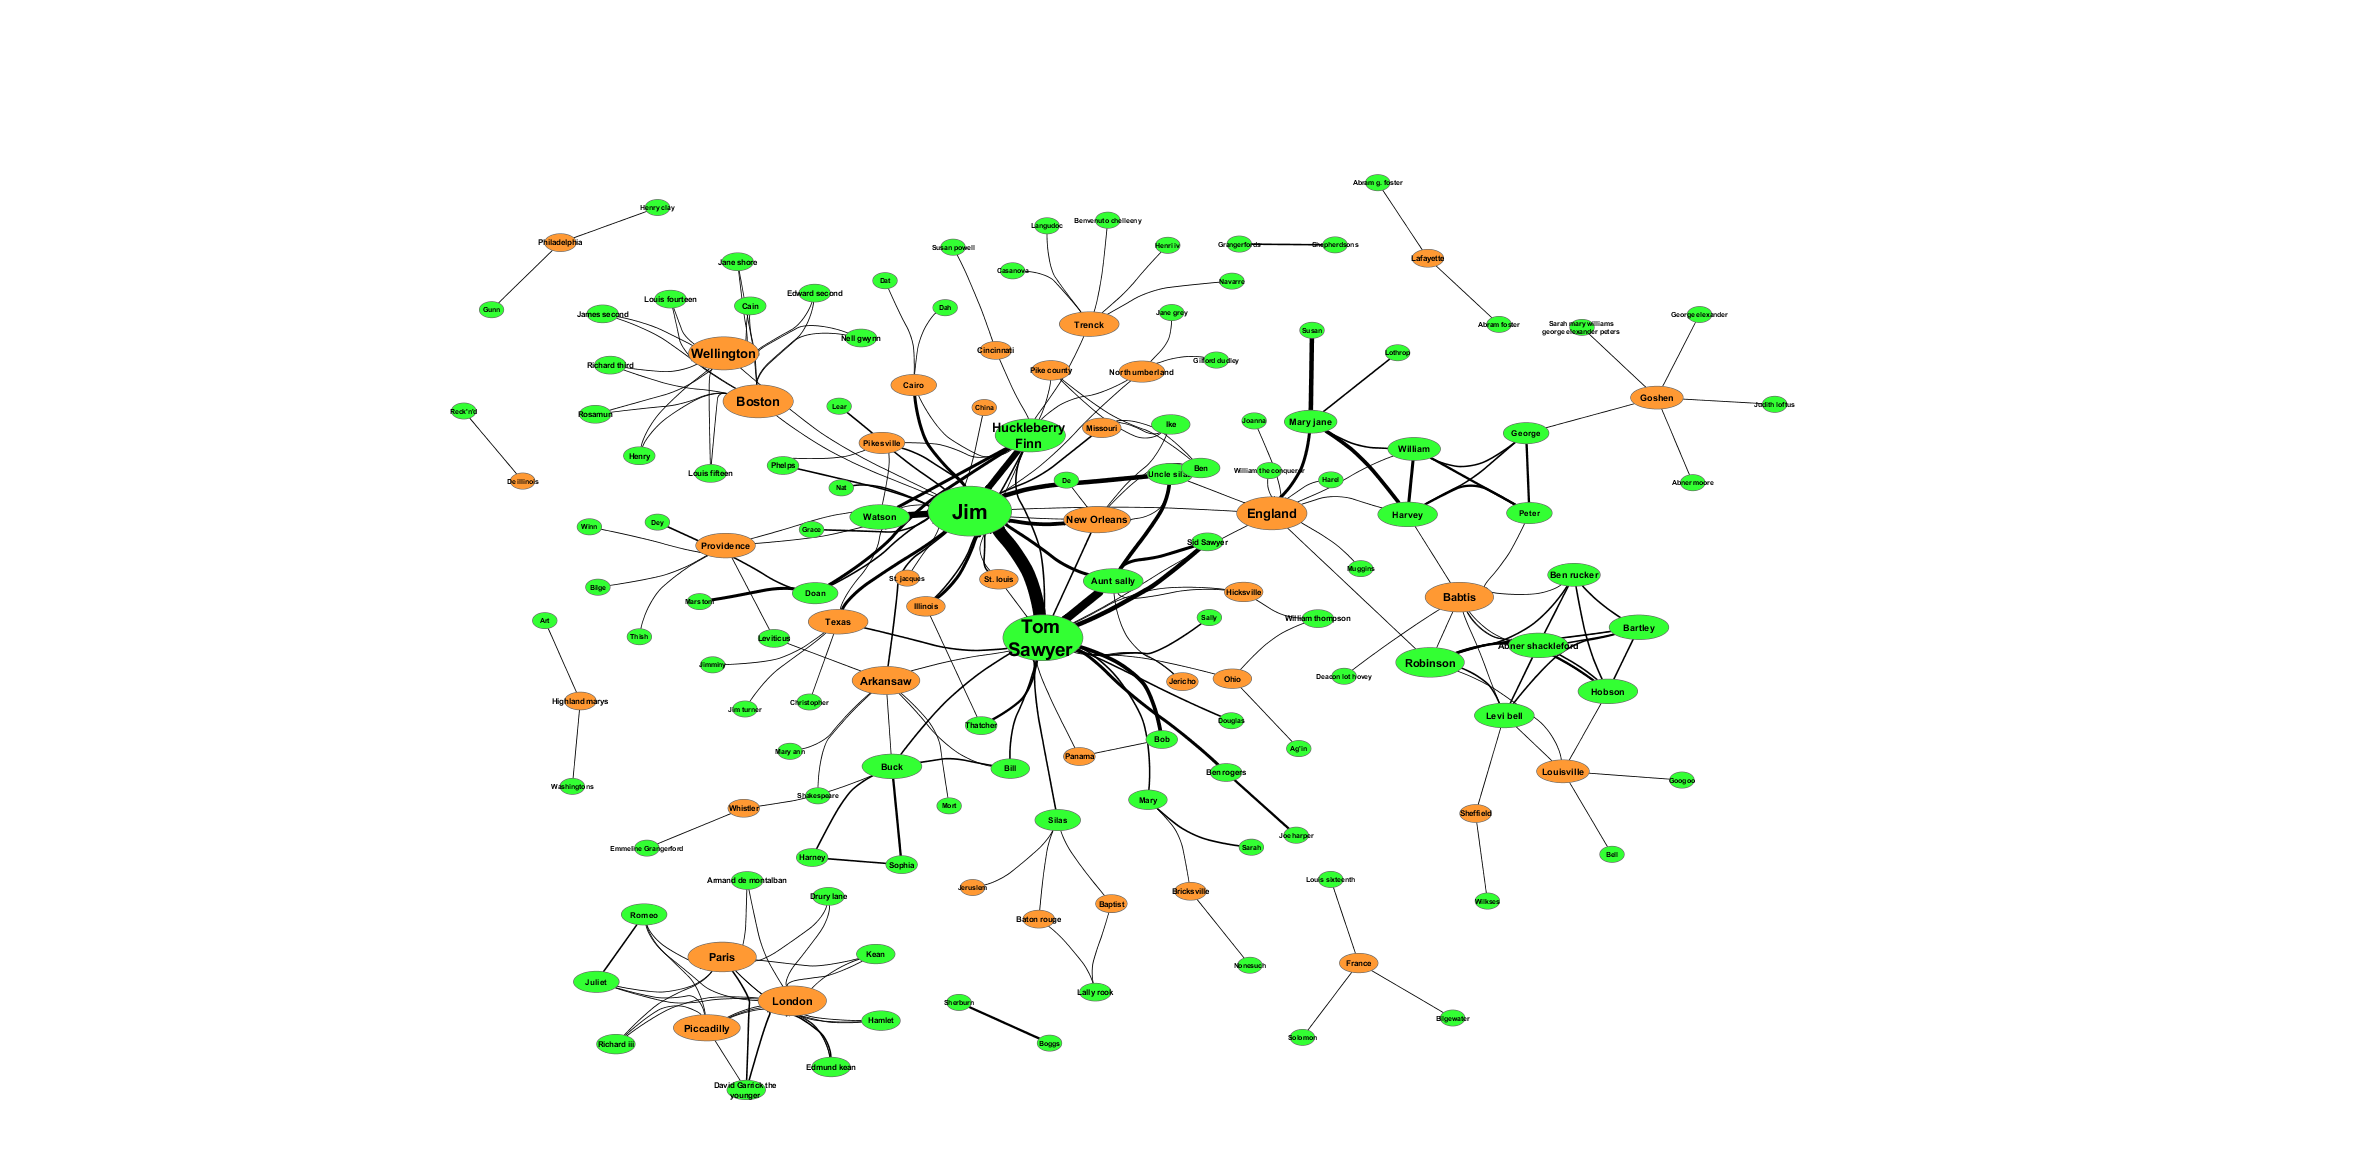

In [38]:
Image(filename='data/Huckleberry_Finn_Zoom_Out.png')

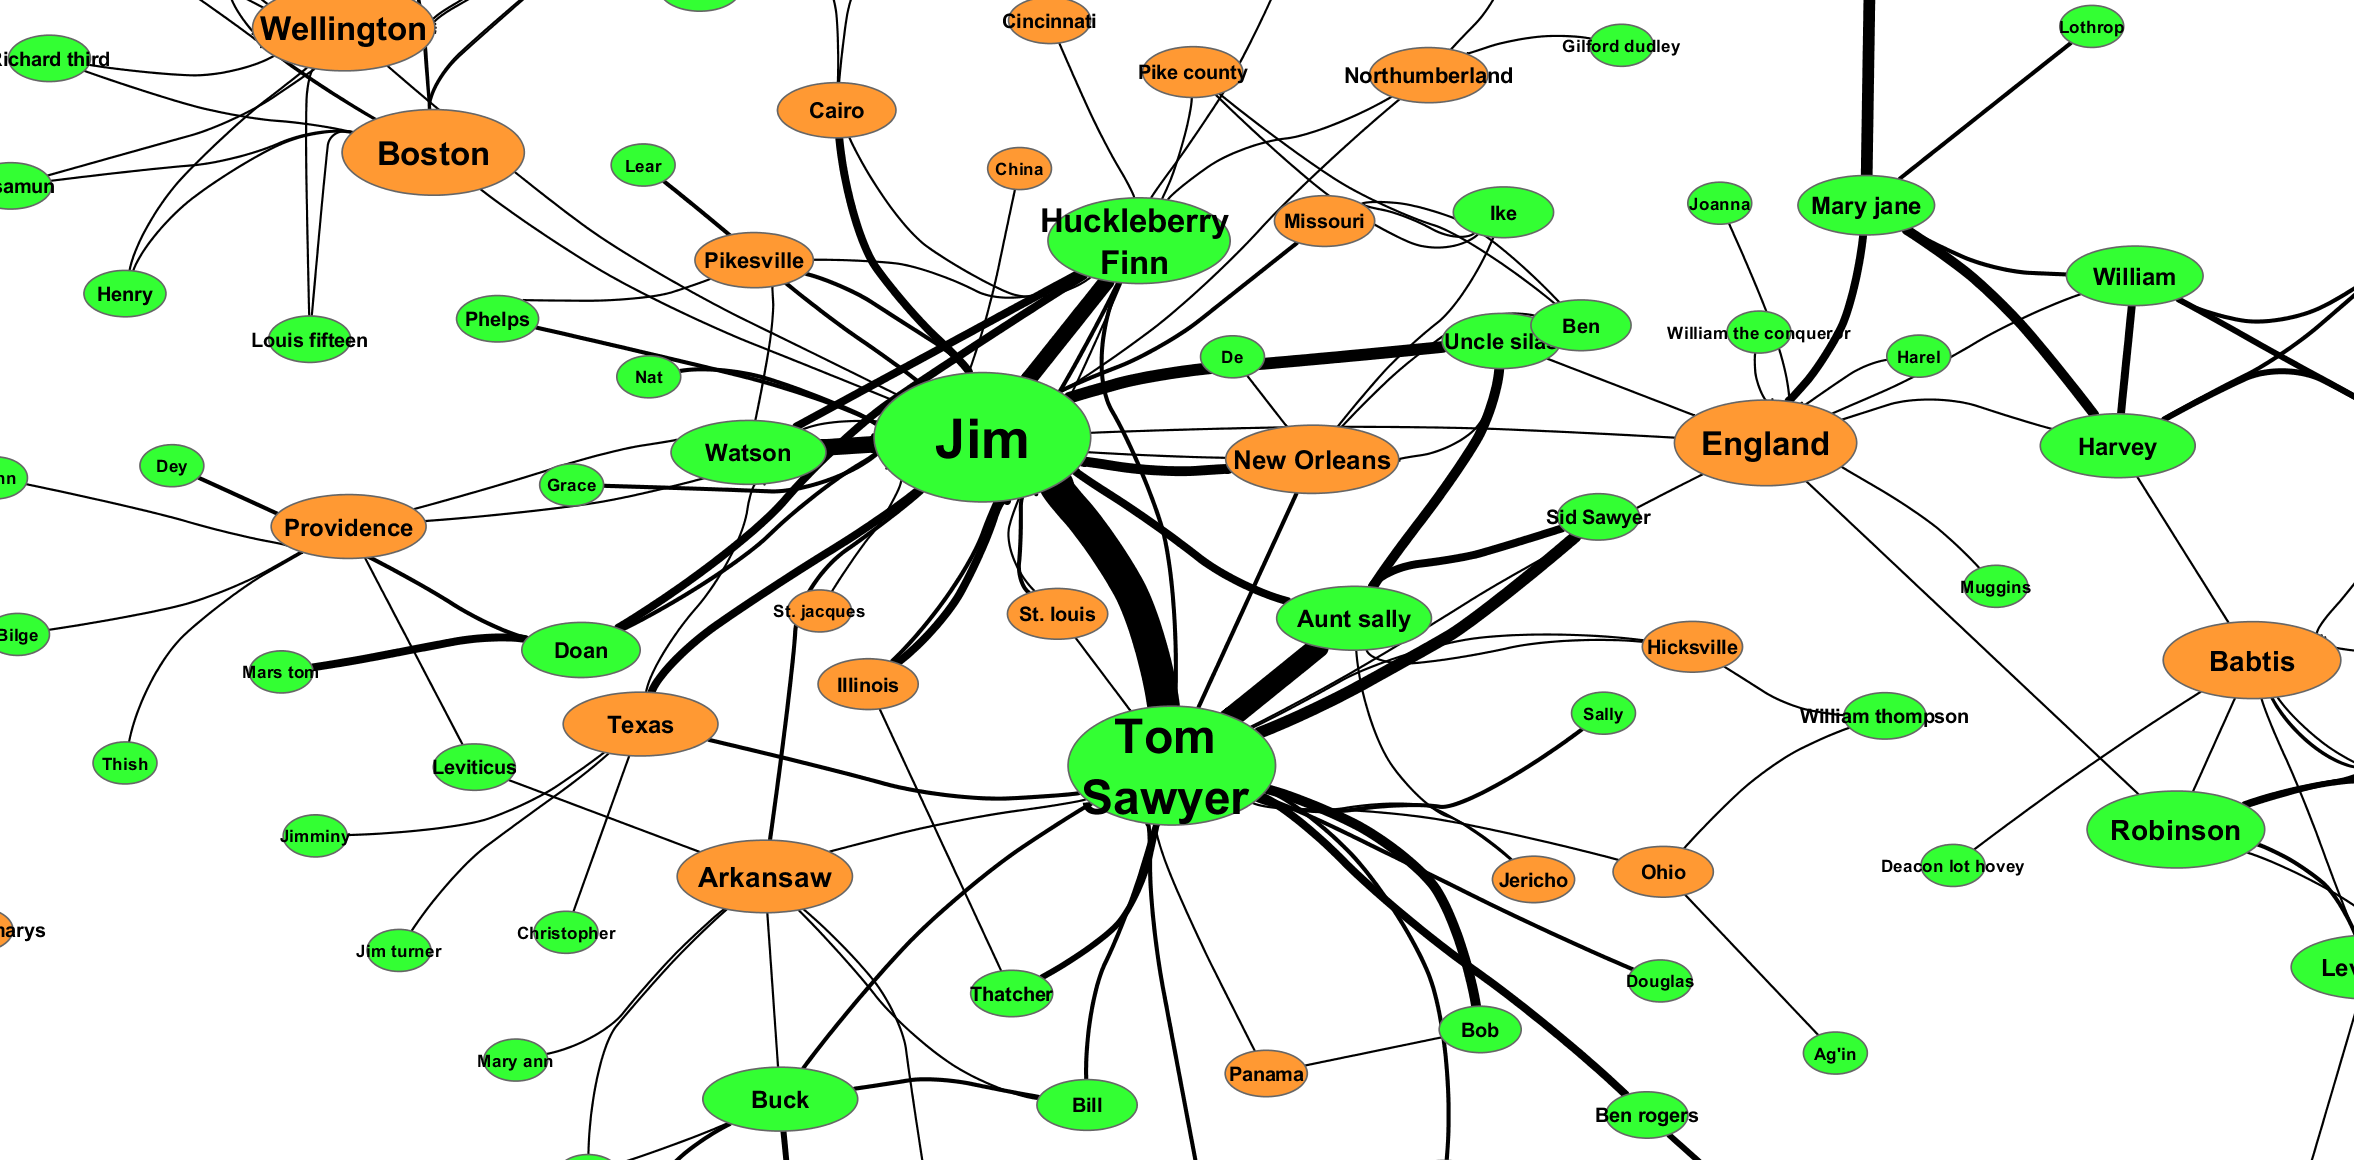

In [39]:
Image(filename='data/Huckleberry_Finn_Zoom_In.png')

People nodes are colored green. <br>
Places nodes are colored orange. <br>
Node size denotes how many distinct people were mentioned with that person or place. <br>
Edge width denotes how many times (in how many paragraphs) two entities were mentioned together.

# Some insights

Without ever reading "The Adventures of Huckleberry Finn", we can come to the following conclusions: 
- Huckleberry Finn, Tom Sawyer, and Jim are the main characters of the book.
- The story takes place in different parts of the world, including Middle east, Europe and the USA.
- Jim and Tom Sawyer had a lot of time together, while Huckleberry Finn never met William the Conqueror.